# Potter2Vec

In [0]:
from __future__ import absolute_import, division, print_function

In [0]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

In [0]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [0]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Set up logging**

In [0]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

**Download NLTK tokenizer models (only the first time)**

In [0]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Metnin Hazırlanması

**Kitaplar klasörden okunur**

In [0]:
import io
from google.colab import files
uploaded = files.upload()
book_filenames = sorted(uploaded)
#book_filenames = sorted(glob.glob("data/*.txt"))

Saving narnia.txt to narnia.txt


In [0]:
print("Found books:")
book_filenames

Found books:


['narnia.txt']

**Bütün kitaplar tek bir yerde birleştirilir**

In [0]:
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'narnia.txt'...
Corpus is now 1770318 characters long



**NLTK Kütüphanesi ile anlama etkisi olmayan kelimeler temizlenir**

In [0]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [0]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [0]:
#convert into a list of words
#rtemove unnnecessary,, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [0]:
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [0]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 328,967 tokens


## Word2Vec Oluşturulması ve Eğitilmesi

In [0]:
#ONCE we have vectors
#step 3 - build model
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

In [0]:
word2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [0]:
word2vec.build_vocab(sentences)

2020-01-02 12:45:49,255 : INFO : collecting all words and their counts
2020-01-02 12:45:49,257 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-01-02 12:45:49,297 : INFO : PROGRESS: at sentence #10000, processed 143378 words, keeping 8359 word types
2020-01-02 12:45:49,329 : INFO : PROGRESS: at sentence #20000, processed 282296 words, keeping 11667 word types
2020-01-02 12:45:49,342 : INFO : collected 12354 word types from a corpus of 328967 raw words and 23321 sentences
2020-01-02 12:45:49,343 : INFO : Loading a fresh vocabulary
2020-01-02 12:45:49,360 : INFO : effective_min_count=3 retains 5636 unique words (45% of original 12354, drops 6718)
2020-01-02 12:45:49,361 : INFO : effective_min_count=3 leaves 320464 word corpus (97% of original 328967, drops 8503)
2020-01-02 12:45:49,382 : INFO : deleting the raw counts dictionary of 12354 items
2020-01-02 12:45:49,384 : INFO : sample=0.001 downsamples 63 most-common words
2020-01-02 12:45:49,385 : INFO : dow

In [0]:
print("Word2Vec vocabulary length:", len(word2vec.wv.vocab))

Word2Vec vocabulary length: 5636


**Start training, this might take a minute or two...**

In [0]:
word2vec.train(sentences,total_examples=word2vec.corpus_count, epochs=word2vec.iter)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """Entry point for launching an IPython kernel.
2020-01-02 12:46:04,226 : INFO : training model with 2 workers on 5636 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2020-01-02 12:46:05,326 : INFO : EPOCH 1 - PROGRESS: at 51.07% examples, 113588 words/s, in_qsize 3, out_qsize 0
2020-01-02 12:46:06,173 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-02 12:46:06,243 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-02 12:46:06,244 : INFO : EPOCH - 1 : training on 328967 raw words (240186 effective words) took 2.0s, 119731 effective words/s
2020-01-02 12:46:07,313 : INFO : EPOCH 2 - PROGRESS: at 51.07% examples, 116628 words/s, in_qsize 3, out_qsize 0
2020-01-02 12:46:08,156 : INFO : worker thread finished; awaiting finish of 1 more th

(1201121, 1644835)

**Eğitilen modelin Kaydedilmesi**

In [0]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [0]:
word2vec.save(os.path.join("trained", "word2vec.w2v"))

2020-01-02 12:46:24,757 : INFO : saving Word2Vec object under trained/potter2vec.w2v, separately None
2020-01-02 12:46:24,759 : INFO : not storing attribute vectors_norm
2020-01-02 12:46:24,761 : INFO : not storing attribute cum_table
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2020-01-02 12:46:24,974 : INFO : saved trained/potter2vec.w2v


## Kaydedilen Modelin Yüklenmesi.

In [0]:
word2vec = w2v.Word2Vec.load(os.path.join("trained", "word2vec.w2v"))

2020-01-02 12:46:30,407 : INFO : loading Word2Vec object from trained/potter2vec.w2v
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2020-01-02 12:46:30,546 : INFO : loading wv recursively from trained/potter2vec.w2v.wv.* with mmap=None
2020-01-02 12:46:30,546 : INFO : setting ignored attribute vectors_norm to None
2020-01-02 12:46:30,551 : INFO : loading vocabulary recursively from trained/potter2vec.w2v.vocabulary.* with mmap=None
2020-01-02 12:46:30,553 : INFO : loading trainables recursively from trained/potter2vec.w2v.trainables.* with mmap=None
2020-01-02 12:46:30,553 : INFO : setting ignored attribute cum_table to None
2020-01-02 12:46:30,555 : INFO : loaded trained/potter2vec.w

### TSNE ile Eğitilen Modelin Görselleştirilmesi

In [0]:
#my video - how to visualize a dataset easily
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [0]:
all_word_vectors_matrix = word2vec.wv.syn0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


**Metinde geçen kelimelerin tsne ile koordinatlarının belirlenmesi**

In [0]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [0]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[word2vec.wv.vocab[word].index])
            for word in word2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [0]:
points.head(10)

,word,x,y
0,ONCE,27.189535,56.665928
1,there,-9.731137,-14.095560
2,were,0.883952,-20.157694
3,four,1.957156,-18.994036
4,children,-24.131737,-18.315685
5,whose,-53.192543,24.861073
6,names,-29.433229,15.046349
7,Peter,-70.135101,17.588438
8,Susan,-70.677757,17.168983
9,Edmund,-70.789093,17.237616


In [0]:
sns.set_context("poster")

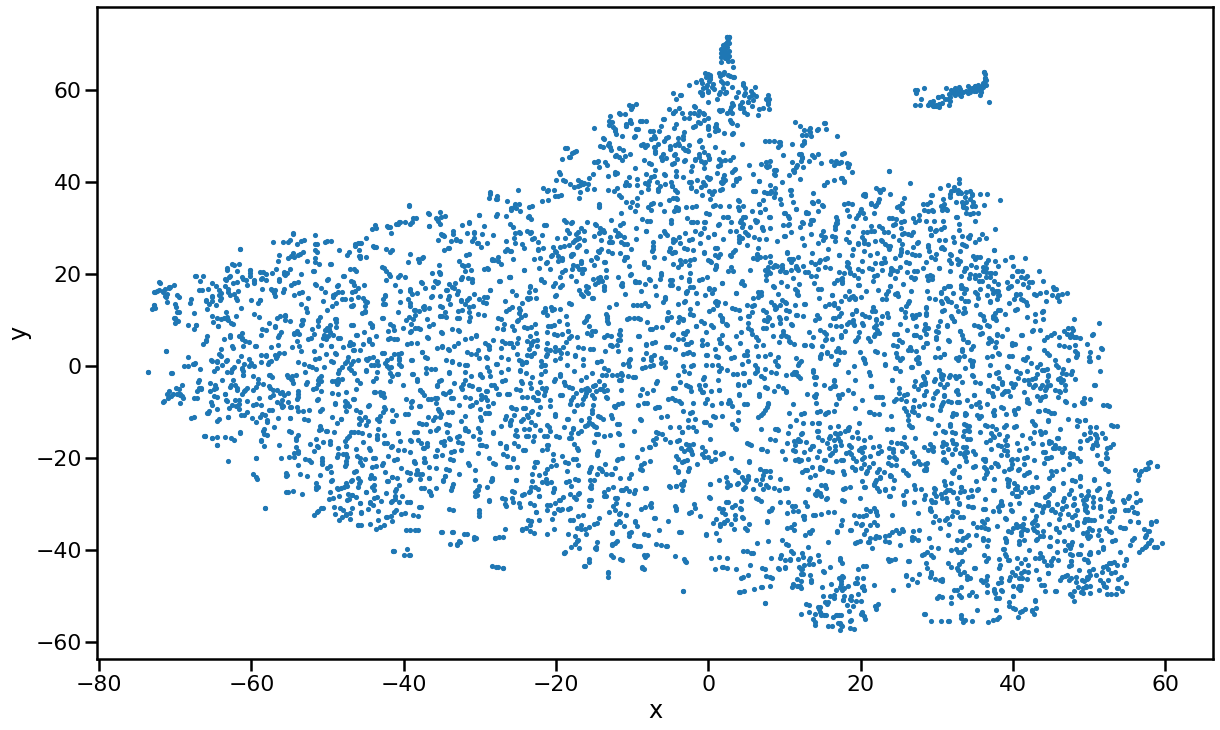

In [0]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [0]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

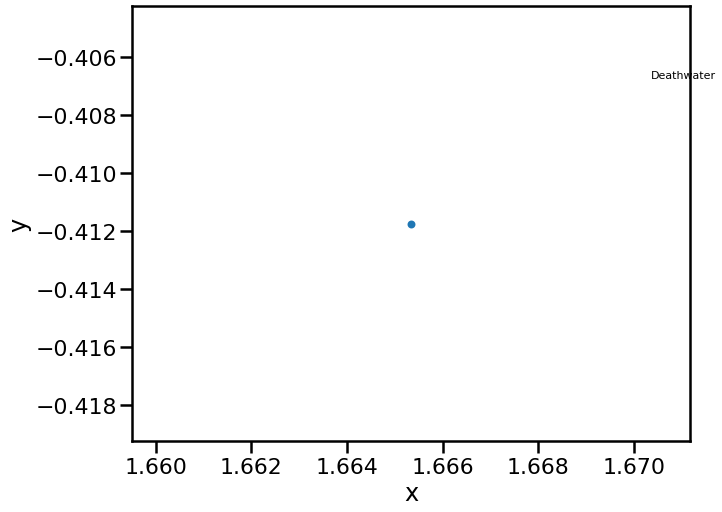

In [0]:
plot_region(x_bounds=(0.0, 5.2), y_bounds=(-0.5, -0.1))

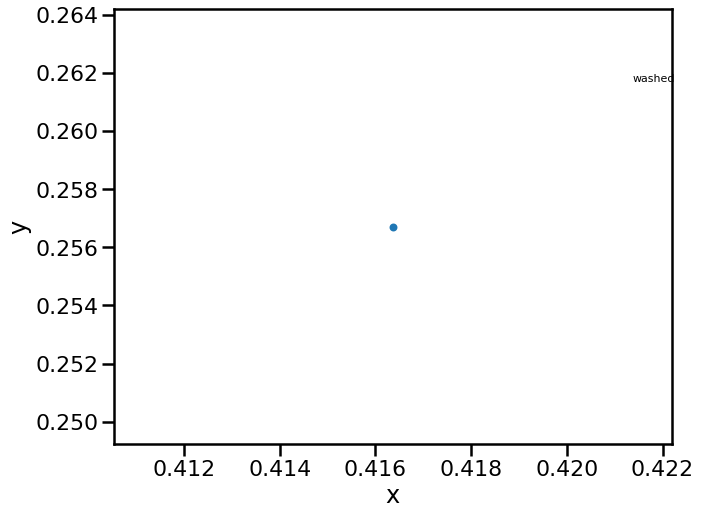

In [0]:
plot_region(x_bounds=(0, 1.25), y_bounds=(0, 1.25))

### Verilen kelimeler arasında anlamsal ilişkilerin keşfedilmesi

In [0]:
word2vec.most_similar("Professor") 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Magician', 0.9568250179290771),
 ('nonsense', 0.9557068347930908),
 ('Ginger', 0.9496095180511475),
 ('Raven', 0.9485408067703247),
 ('Boy', 0.947632908821106),
 ('Place', 0.9475997686386108),
 ('Elephant', 0.9472899436950684),
 ('Voice', 0.9457525014877319),
 ('shame', 0.9436463117599487),
 ('Hush', 0.9434679746627808)]

In [0]:
word2vec.most_similar("Susan") 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Puddleglum', 0.9436842799186707),
 ('Edmund', 0.9171192646026611),
 ('Polly', 0.9165785312652588),
 ('Scrubb', 0.9120451807975769),
 ('Peter', 0.9087842702865601),
 ('Cabby', 0.9064791202545166),
 ('Hwin', 0.9054273962974548),
 ('Aravis', 0.9052295088768005),
 ('Corin', 0.9019953012466431),
 ('Lasaraleen', 0.8952590823173523)]

In [0]:
word2vec.most_similar("Lucy")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Digory', 0.9111255407333374),
 ('Jill', 0.9080235958099365),
 ('Lasaraleen', 0.9030321836471558),
 ('Aravis', 0.8974764943122864),
 ('Polly', 0.8937195539474487),
 ('Eustace', 0.8750712275505066),
 ('Scrubb', 0.8716803789138794),
 ('Susan', 0.87098228931427),
 ('Edmund', 0.8682566285133362),
 ('Hwin', 0.858657956123352)]

In [0]:
word2vec.most_similar("Peter")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Edmund', 0.9183268547058105),
 ('Puddleglum', 0.9119216203689575),
 ('Susan', 0.9087842702865601),
 ('Cabby', 0.8996710777282715),
 ('Trumpkin', 0.8926073312759399),
 ('Corin', 0.884243369102478),
 ('Drinian', 0.8736177682876587),
 ('Hwin', 0.8702486753463745),
 ('Strawberry', 0.8692483901977539),
 ('Beaver', 0.8665672540664673)]

In [0]:
word2vec.most_similar("Edmund")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Puddleglum', 0.9238325357437134),
 ('Scrubb', 0.9191397428512573),
 ('Peter', 0.9183268547058105),
 ('Susan', 0.9171192646026611),
 ('Polly', 0.9119811058044434),
 ('Eustace', 0.9020618200302124),
 ('Corin', 0.9011728167533875),
 ('Digory', 0.8936337232589722),
 ('Cabby', 0.8919730186462402),
 ('Lasaraleen', 0.8904264569282532)]

**Kelime çiftleri arasındaki pozitif-negatif ilişkinin keşfedilmesi**

In [0]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = word2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [0]:
nearest_similarity_cosmul("Professor", "Lucy", "Peter") 
nearest_similarity_cosmul("Faun", "Narnia", "Tumnus")


Professor is related to Lucy, as High is related to Peter
Faun is related to Narnia, as girl is related to Tumnus


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  after removing the cwd from sys.path.


'girl'